In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = (225, 400)
batch_size = 32
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/detect_planes/img/',
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    validation_split = 0.2,
    seed = seed,
    subset = "training")

type(train_ds)
print(train_ds)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/detect_planes/img/',
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    validation_split = 0.2,
    seed = seed,
    subset = "validation")

type(validation_ds)
print(validation_ds)

Found 1040 files belonging to 2 classes.
Using 832 files for training.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>
Found 1040 files belonging to 2 classes.
Using 208 files for validation.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>


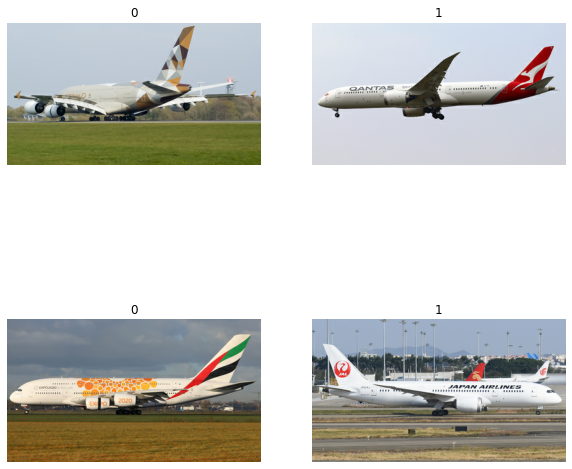

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

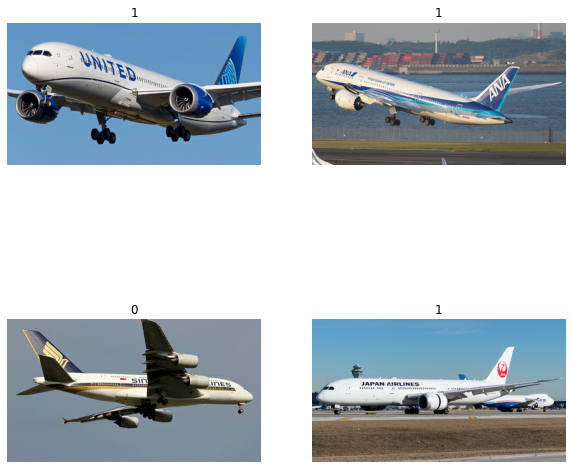

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in validation_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [5]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)

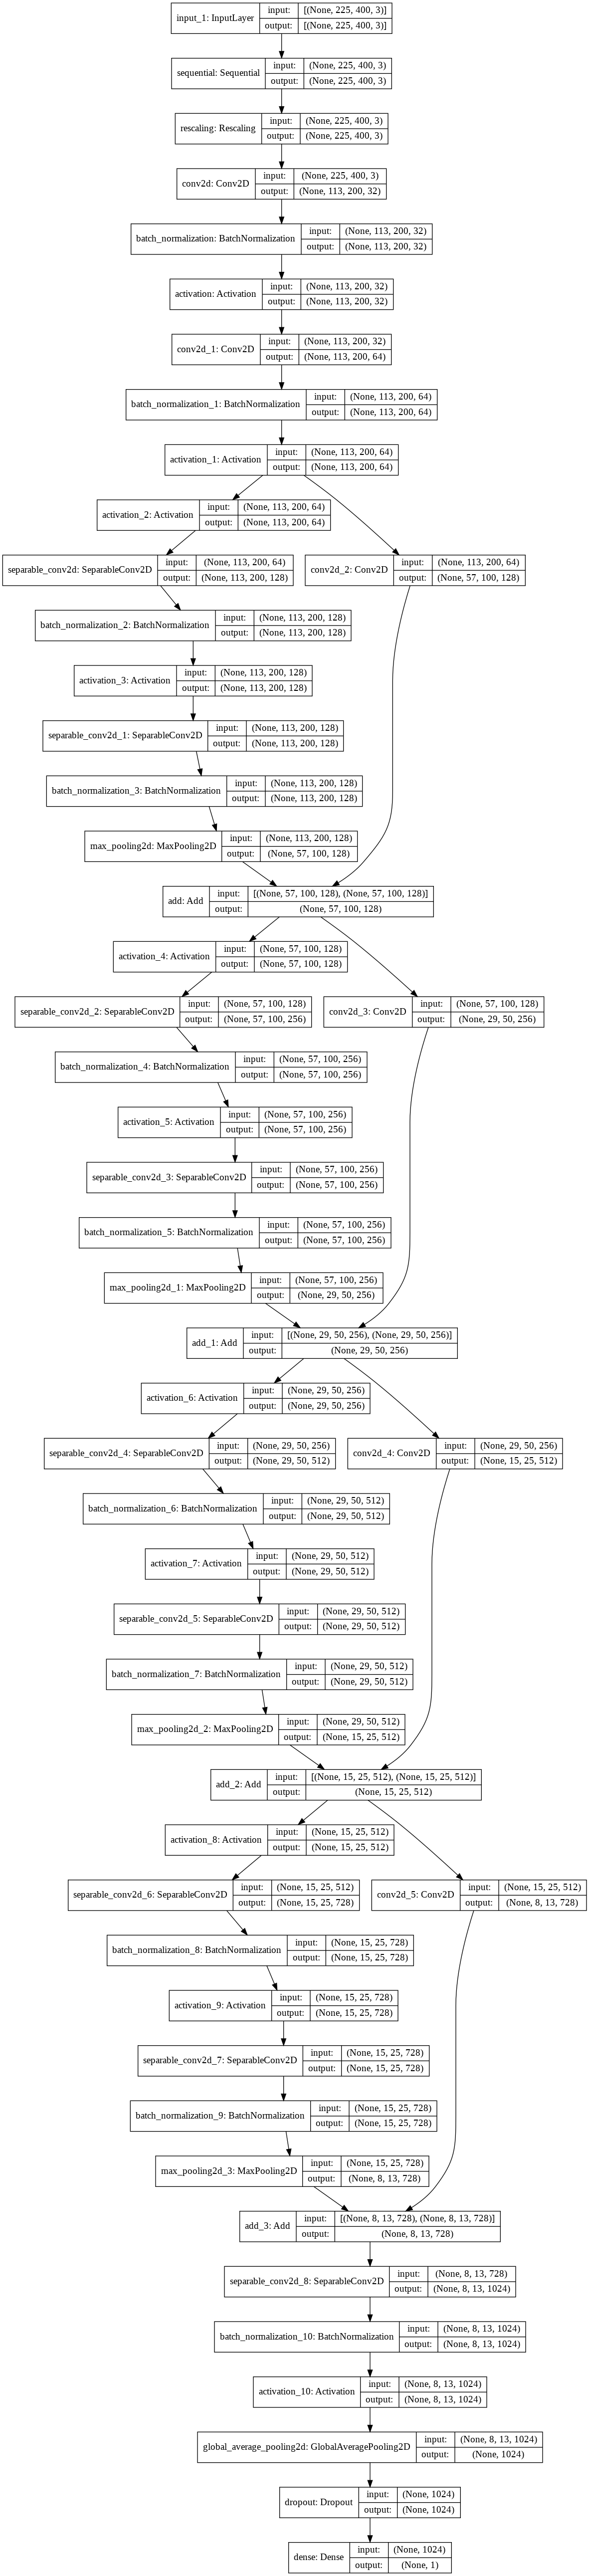

In [7]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)

  # Entry block
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Project residual
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes
  
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
epochs = 5  # In practice you will need at least 50 epochs

callbacks = [
  keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/5
26/26 [==============================] - 345s 9s/step - loss: 0.8397 - accuracy: 0.5278 - val_loss: 0.6931 - val_accuracy: 0.5385
Epoch 2/5
26/26 [==============================] - 15s 552ms/step - loss: 0.7052 - accuracy: 0.6048 - val_loss: 0.6979 - val_accuracy: 0.4567
Epoch 3/5
26/26 [==============================] - 15s 544ms/step - loss: 0.6882 - accuracy: 0.6434 - val_loss: 0.7016 - val_accuracy: 0.4567
Epoch 4/5
26/26 [==============================] - 15s 546ms/step - loss: 0.5959 - accuracy: 0.6814 - val_loss: 0.7229 - val_accuracy: 0.4567
Epoch 5/5
26/26 [==============================] - 15s 546ms/step - loss: 0.5425 - accuracy: 0.7311 - val_loss: 0.7147 - val_accuracy: 0.4567


In [10]:
predictions = model.predict(validation_ds, batch_size=128)

In [2]:
score = predictions[0]
print('This image is %.2f A380 and %.2f B787.' % (score, 1 - score))

NameError: ignored

In [ ]:
predictions

array([[0.4889953 ],
       [0.52205634],
       [0.51237005],
       [0.5016941 ],
       [0.5023547 ],
       [0.50347173],
       [0.5013702 ],
       [0.52525616],
       [0.488991  ],
       [0.49628899],
       [0.5003878 ],
       [0.49678648],
       [0.52220696],
       [0.5022942 ],
       [0.50437987],
       [0.5030778 ],
       [0.5138331 ],
       [0.51595646],
       [0.5191686 ],
       [0.49497354],
       [0.49033618],
       [0.5245449 ],
       [0.53190845],
       [0.5234374 ],
       [0.524697  ],
       [0.52096194],
       [0.5128036 ],
       [0.5328802 ],
       [0.5058984 ],
       [0.50381476],
       [0.5122141 ],
       [0.4949206 ],
       [0.5131982 ],
       [0.51296616],
       [0.52147585],
       [0.53519607],
       [0.4964516 ],
       [0.52988464],
       [0.4969826 ],
       [0.50161225],
       [0.50433445],
       [0.51135856],
       [0.50181854],
       [0.50762135],
       [0.50721   ],
       [0.517997  ],
       [0.50515133],
       [0.491